<a href="https://colab.research.google.com/github/JaniVarga/Skin_detection/blob/main/DeepLabv3_data_aug_plus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision.models import segmentation

In [2]:
weights = torchvision.models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms.describe()

'Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[520]`` using ``interpolation=InterpolationMode.BILINEAR``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.'

In [3]:
auto_transforms

SemanticSegmentation(
    resize_size=[520]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [4]:
from torchvision.transforms import v2

In [5]:
auto_transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize((520, 520)),
    v2.ToDtype(dtype=torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
    # v2.ColorJitter(brightness=0.2,
                  #  contrast=0.2,
                  #  saturation=0.2,
                  #  hue=0.1),
    # v2.GaussianNoise(mean=0, sigma=0.1)
])
auto_transforms

Compose(
      ToImage()
      Resize(size=[520, 520], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)

In [6]:
model = segmentation.deeplabv3_mobilenet_v3_large(weights=weights)

In [7]:
try:
  import torchinfo

except:
  print("Install torchinfo...")
  !pip --quiet install torchinfo
  import torchinfo
  print("Torchinfo is installed and import.")

else:
  print("torchinfo is already installed.")

torchinfo is already installed.


In [8]:
# Print with summary
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 520, 520),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
DeepLabV3 (DeepLabV3)                                        [1, 3, 520, 520]     [1, 21, 520, 520]    --                   True
├─IntermediateLayerGetter (backbone)                         [1, 3, 520, 520]     [1, 960, 33, 33]     --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 520, 520]     [1, 16, 260, 260]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 520, 520]     [1, 16, 260, 260]    432                  True
│    │    └─BatchNorm2d (1)                                  [1, 16, 260, 260]    [1, 16, 260, 260]    32                   True
│    │    └─Hardswish (2)                                    [1, 16, 260, 260]    [1, 16, 260, 260]    --                   --
│    └─InvertedResidual (1)                                  [1, 16, 260, 260]    [1, 16, 260,

In [9]:
model.classifier[4]

Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))

In [10]:
from torch import nn

In [11]:
new_classifier = nn.Conv2d(in_channels=256,
              out_channels= 1,
              kernel_size=1,
              stride=1)

In [12]:
model.classifier[4] = new_classifier

In [13]:
summary(model=model,
        input_size=(1, 3, 520, 520),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
DeepLabV3 (DeepLabV3)                                        [1, 3, 520, 520]     [1, 21, 520, 520]    --                   True
├─IntermediateLayerGetter (backbone)                         [1, 3, 520, 520]     [1, 960, 33, 33]     --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 520, 520]     [1, 16, 260, 260]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 520, 520]     [1, 16, 260, 260]    432                  True
│    │    └─BatchNorm2d (1)                                  [1, 16, 260, 260]    [1, 16, 260, 260]    32                   True
│    │    └─Hardswish (2)                                    [1, 16, 260, 260]    [1, 16, 260, 260]    --                   --
│    └─InvertedResidual (1)                                  [1, 16, 260, 260]    [1, 16, 260,

In [14]:
from pathlib import Path
import pathlib

In [15]:
zip_path = "/content/dataset.zip"

In [16]:
import zipfile

try:
    print("Extracting zip file...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
      zip_ref.extractall(path="/content")
      print("Data is extracted.")

except FileNotFoundError:
    print("Data zip file is not found!")

Extracting zip file...
Data is extracted.


In [17]:
train_dir = Path("/content/dataset/train")
test_dir = Path("/content/dataset/val")

In [18]:
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [19]:
class CustomDatset(Dataset):
  def __init__(self, root_dir, image_transform=None, data_augmentation=None):
    super().__init__()
    self.root_dir = root_dir
    self.image_transform = image_transform
    self.data_augmentation = data_augmentation
    self.image_paths = sorted(list(glob.glob(f"{root_dir}/images/*.*")))
    self.masks_paths = sorted(list(glob.glob(f"{root_dir}/masks/*.*")))

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, index):
    image= Image.open(self.image_paths[index])
    mask = Image.open(self.masks_paths[index])


    base_transforms = v2.Compose([
        v2.ToImage(),
        v2.Resize((520, 520)),
        v2.ToDtype(dtype=torch.float32, scale=True)])

    mask = base_transforms(mask)
    image = base_transforms(image)


    def common_augmentation(image, mask): # Concatenate image and mask to ensure consistent transformation
      combined = torch.cat([image, mask], dim=0)
      augmented_combined = self.data_augmentation(combined) # Split the rotated result back into image and mask
      image = augmented_combined[:3]
      mask = augmented_combined[3:]

      return image, mask

    if self.data_augmentation:
      image, mask = common_augmentation(image,mask)


    if self.image_transform:
      image = self.image_transform(image)

    return image, mask

In [20]:
data_augmentation = v2.Compose([
    v2.RandomRotation(degrees=15),
    v2.RandomHorizontalFlip(p=0.5),
    # v2.ElasticTransform(alpha=10, sigma=2),
    ])

In [21]:
auto_transforms = v2.Compose([
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
    v2.ColorJitter(brightness=0.2,
                   contrast=0.2,
                   saturation=0.2,
                   hue=0.05),
    v2.GaussianNoise(mean=0, sigma=0.1)
])
auto_transforms

Compose(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
      ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.05, 0.05))
      GaussianNoise(mean=0, sigma=0.1, clip=True)
)

In [22]:
train_dataset = CustomDatset(root_dir=train_dir,
                            image_transform=auto_transforms,
                            data_augmentation=data_augmentation)

In [23]:
val_dataset = CustomDatset(root_dir=test_dir,
                            image_transform=auto_transforms,
                            data_augmentation=data_augmentation)

In [24]:
len(train_dataset), len(val_dataset)

(3108, 791)

In [25]:
image, mask = train_dataset.__getitem__(95)

In [26]:
image.shape, mask.shape

(torch.Size([3, 520, 520]), torch.Size([1, 520, 520]))

In [27]:
image.dtype, mask.dtype

(torch.float32, torch.float32)

In [28]:
len(mask.unique())

2

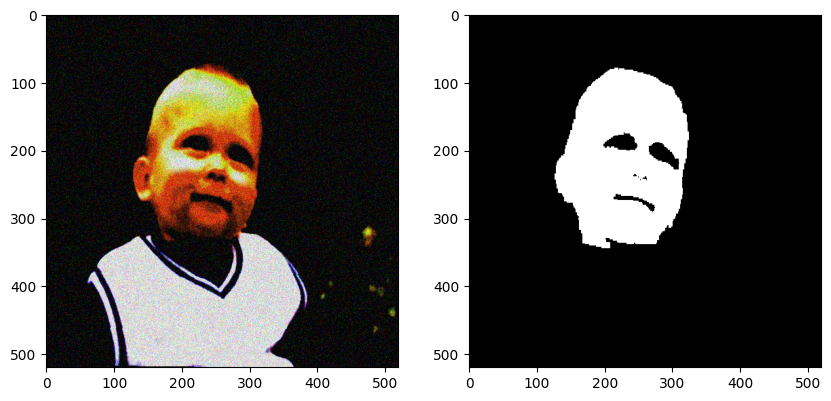

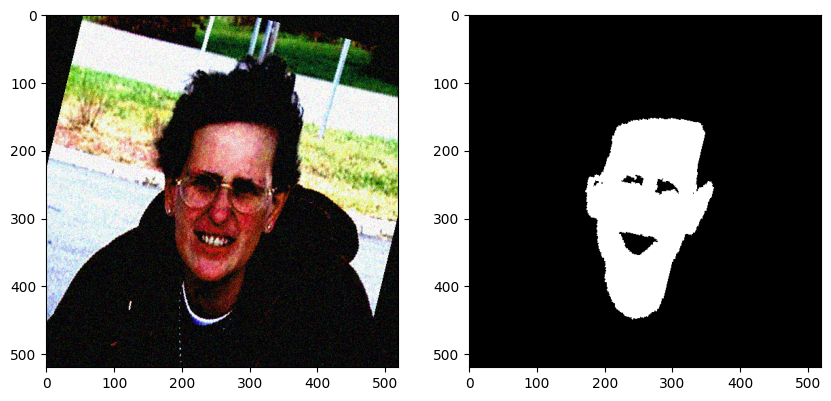

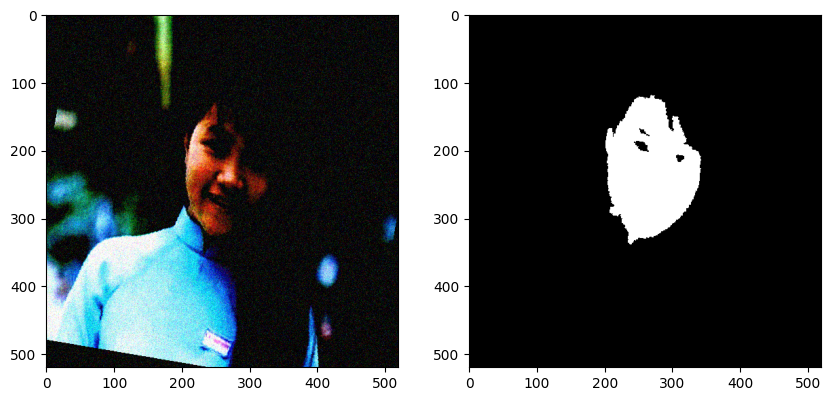

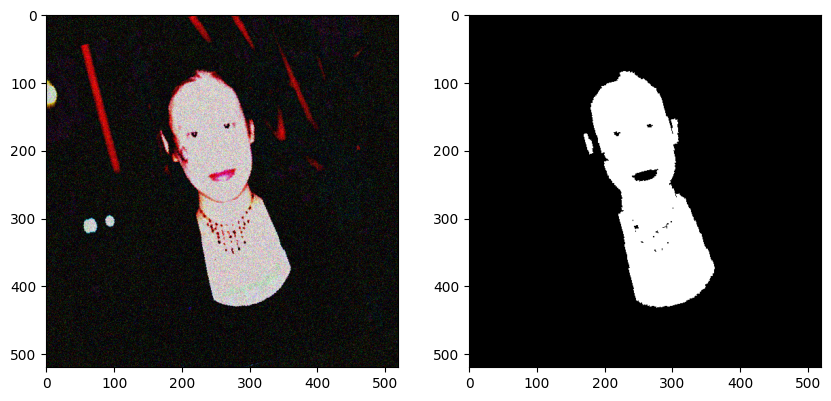

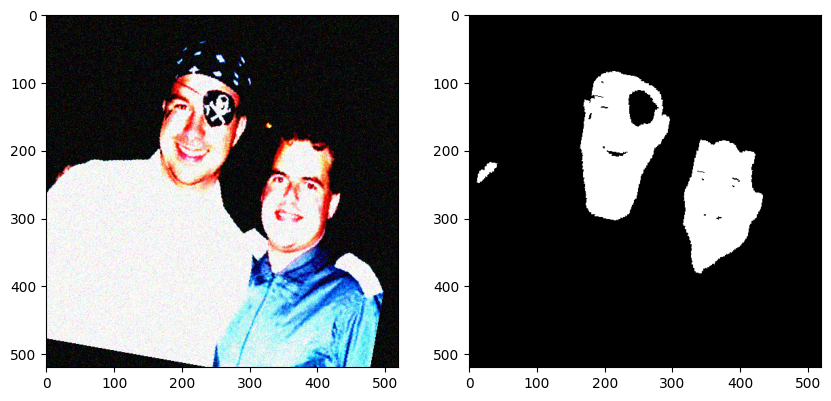

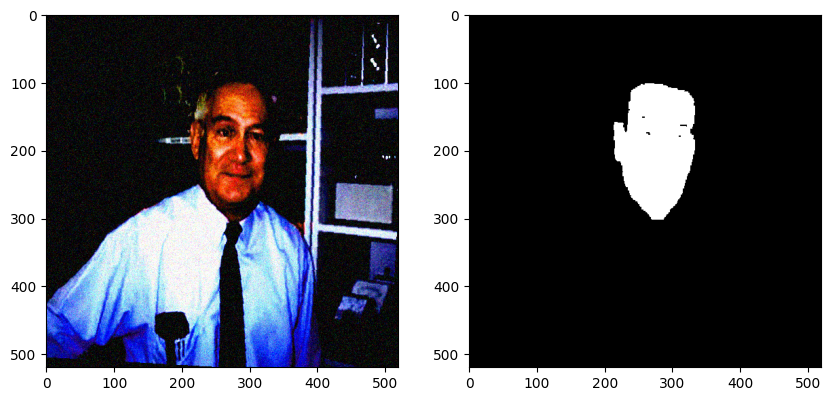

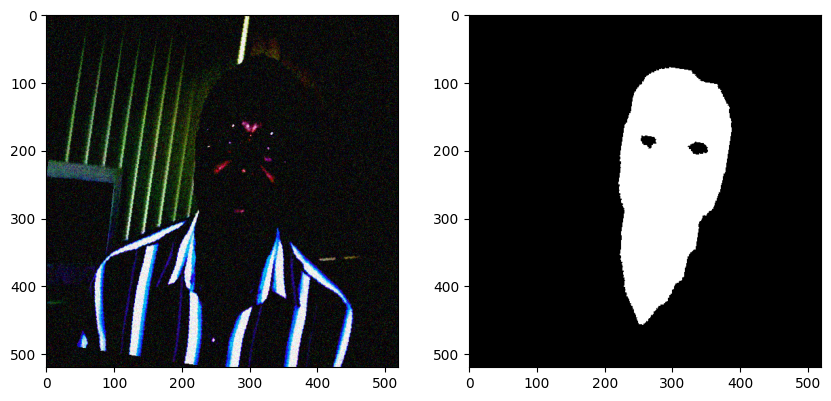

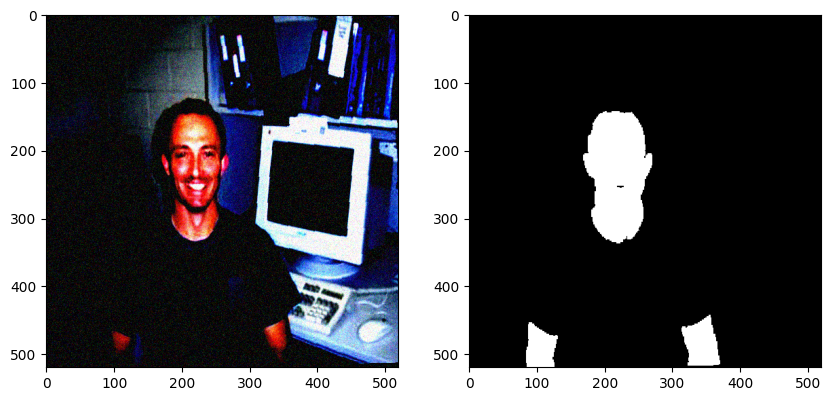

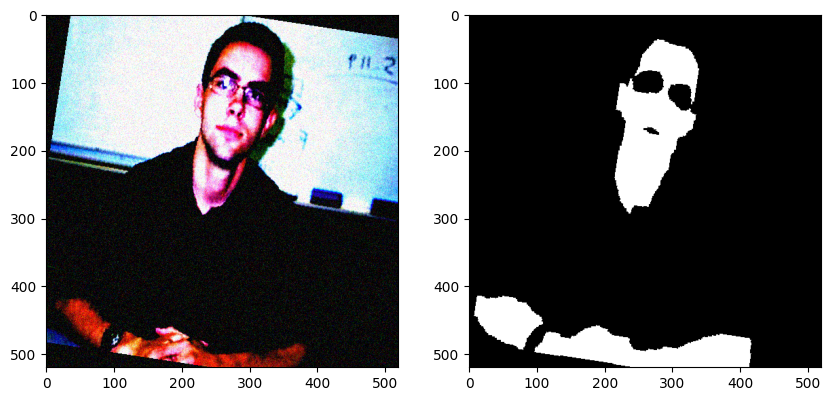

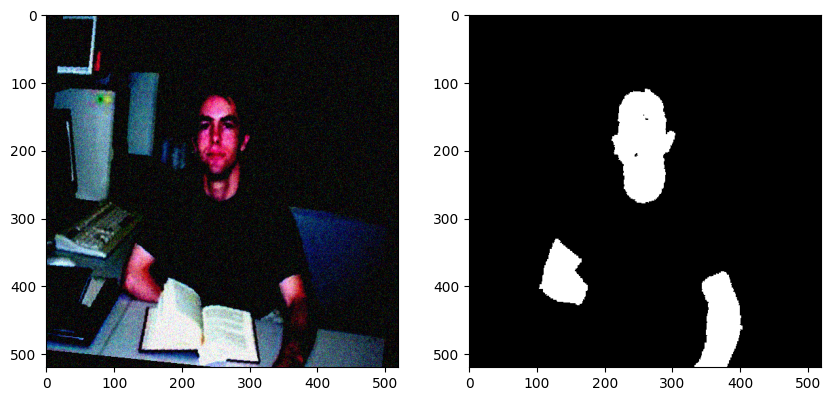

In [29]:
for i in range(10):
  image, mask = train_dataset.__getitem__(i)

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
  axes[0].imshow(image.permute(1, 2, 0))
  axes[1].imshow(mask.squeeze(0), cmap="gray")

In [30]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=16,
                              shuffle=True)

test_dataloader = DataLoader(dataset=val_dataset,
                             batch_size=16,
                             shuffle=False)

len(train_dataloader), len(test_dataloader)

(195, 50)

In [31]:
train_dataloader.dataset.image_paths[0]

'/content/dataset/train/images/0001.jpeg'

In [32]:
class EarlyStopping:
    def __init__(self, patience=7, delta=0.01, verbose=False, model_name='checkpoint.pt'):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.model_name = model_name

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), f'my_best_checkpoint_{self.model_name}.pth')
        self.val_loss_min = val_loss

In [33]:
# https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch
import torch.nn.functional as F

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [34]:
from torch.optim import lr_scheduler

optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.005)

scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# loss_fn = torch.nn.BCEWithLogitsLoss()
loss_fn = DiceBCELoss()

early_stopping = EarlyStopping(patience=5, verbose=True, model_name="sematic_segmentation")

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [36]:
from tqdm.auto import tqdm

def training(epochs = 5,
             model = model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             optimizer=optimizer,
             loss_fn = loss_fn):

  model.to(device)
  train_losses = []
  test_losses = []

  for epoch in tqdm(range(epochs), leave=True, position=0):
    print(f"\n{'-'*45} \n Epoch: {epoch}")
    train_loss = 0
    test_loss = 0

    model.train()
    for batch, (X, y) in enumerate(tqdm(train_dataloader)):
      X, y = X.to(device), y.to(device)

      y_pred = model(X)["out"]
      loss = loss_fn(y_pred, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item()

    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    print(f"Batch: {batch} | Train Loss: {train_loss:.5f} ")



    model.eval()
    with torch.inference_mode():
      for batch, (X, y) in enumerate(tqdm(test_dataloader)):
        X = X.to(device)
        y = y.to(device)

        y_pred = model(X)["out"]
        loss = loss_fn(y_pred, y)

        test_loss += loss.item()

      test_loss /= len(test_dataloader)
      test_losses.append(test_loss)

      print(f"Learning rate: {scheduler.get_last_lr()[0]:.5f}")
      scheduler.step()
      print(f"Batch: {batch} | Test Loss: {test_loss:.5f}")


      early_stopping(test_loss, model)
      if early_stopping.early_stop:
        print("Early stopping triggered at epoch:", epoch)
        break


  return train_losses, test_losses

In [37]:
test_train_losses, test_validation_losses = training(epochs=50,
                             model=model,
                             train_dataloader=train_dataloader,
                             test_dataloader=test_dataloader,
                             optimizer=optimizer,
                             loss_fn = loss_fn     )

  0%|          | 0/50 [00:00<?, ?it/s]


--------------------------------------------- 
 Epoch: 0


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.49526 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00500
Batch: 49 | Test Loss: 6.75879
Validation loss decreased (inf --> 6.758792).  Saving model ...

--------------------------------------------- 
 Epoch: 1


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.36884 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00450
Batch: 49 | Test Loss: 0.95944
Validation loss decreased (6.758792 --> 0.959438).  Saving model ...

--------------------------------------------- 
 Epoch: 2


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.34243 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00405
Batch: 49 | Test Loss: 0.52396
Validation loss decreased (0.959438 --> 0.523961).  Saving model ...

--------------------------------------------- 
 Epoch: 3


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.31977 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00365
Batch: 49 | Test Loss: 0.34422
Validation loss decreased (0.523961 --> 0.344222).  Saving model ...

--------------------------------------------- 
 Epoch: 4


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.30688 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00328
Batch: 49 | Test Loss: 0.34191
EarlyStopping counter: 1 out of 5

--------------------------------------------- 
 Epoch: 5


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.28253 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00295
Batch: 49 | Test Loss: 0.31181
Validation loss decreased (0.344222 --> 0.311808).  Saving model ...

--------------------------------------------- 
 Epoch: 6


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.27081 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00266
Batch: 49 | Test Loss: 0.27706
Validation loss decreased (0.311808 --> 0.277056).  Saving model ...

--------------------------------------------- 
 Epoch: 7


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.25595 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00239
Batch: 49 | Test Loss: 0.31156
EarlyStopping counter: 1 out of 5

--------------------------------------------- 
 Epoch: 8


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.24896 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00215
Batch: 49 | Test Loss: 0.29866
EarlyStopping counter: 2 out of 5

--------------------------------------------- 
 Epoch: 9


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.24093 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00194
Batch: 49 | Test Loss: 0.27551
EarlyStopping counter: 3 out of 5

--------------------------------------------- 
 Epoch: 10


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.23786 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00174
Batch: 49 | Test Loss: 0.26460
Validation loss decreased (0.277056 --> 0.264598).  Saving model ...

--------------------------------------------- 
 Epoch: 11


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.23054 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00157
Batch: 49 | Test Loss: 0.26081
EarlyStopping counter: 1 out of 5

--------------------------------------------- 
 Epoch: 12


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.21769 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00141
Batch: 49 | Test Loss: 0.25230
Validation loss decreased (0.264598 --> 0.252302).  Saving model ...

--------------------------------------------- 
 Epoch: 13


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.21269 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00127
Batch: 49 | Test Loss: 0.25102
EarlyStopping counter: 1 out of 5

--------------------------------------------- 
 Epoch: 14


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.20842 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00114
Batch: 49 | Test Loss: 0.24683
EarlyStopping counter: 2 out of 5

--------------------------------------------- 
 Epoch: 15


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.20274 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00103
Batch: 49 | Test Loss: 0.24770
EarlyStopping counter: 3 out of 5

--------------------------------------------- 
 Epoch: 16


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.19645 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00093
Batch: 49 | Test Loss: 0.23946
Validation loss decreased (0.252302 --> 0.239459).  Saving model ...

--------------------------------------------- 
 Epoch: 17


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.19179 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00083
Batch: 49 | Test Loss: 0.24002
EarlyStopping counter: 1 out of 5

--------------------------------------------- 
 Epoch: 18


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.18945 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00075
Batch: 49 | Test Loss: 0.23961
EarlyStopping counter: 2 out of 5

--------------------------------------------- 
 Epoch: 19


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.18647 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00068
Batch: 49 | Test Loss: 0.23843
EarlyStopping counter: 3 out of 5

--------------------------------------------- 
 Epoch: 20


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.18384 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00061
Batch: 49 | Test Loss: 0.24173
EarlyStopping counter: 4 out of 5

--------------------------------------------- 
 Epoch: 21


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.18302 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00055
Batch: 49 | Test Loss: 0.23922
EarlyStopping counter: 5 out of 5
Early stopping triggered at epoch: 21


Text(0.5, 1.0, 'Loss')

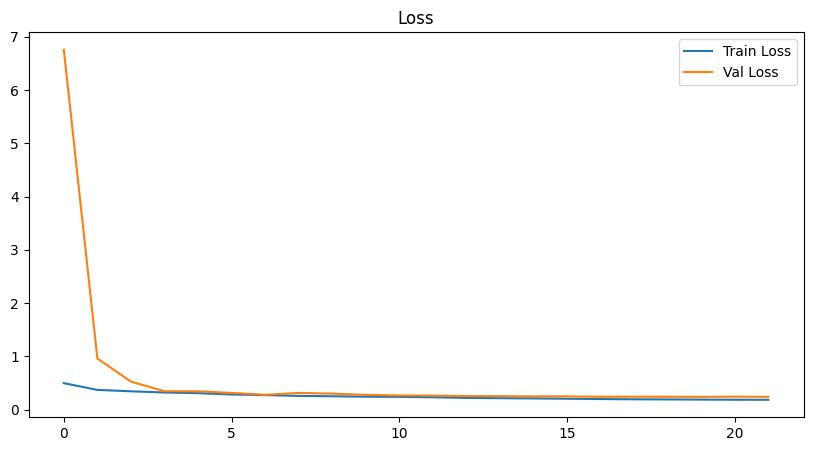

In [38]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))

ax.plot(test_train_losses, label="Train Loss")
ax.plot(test_validation_losses, label="Val Loss")
ax.legend()
ax.set_title("Loss")

In [39]:
def show_result(best_model_path, model):

  test_img_path = "/content/1728293261557.jpeg"
  test_img = Image.open(test_img_path)
  test_img = v2.ToImage()(test_img)
  base_transforms = v2.Compose([
        v2.ToImage(),
        v2.Resize((520, 520)),
        v2.ToDtype(dtype=torch.float32, scale=True)])
  test_img = base_transforms(test_img) # Convert to float32
  test_img = auto_transforms(test_img).unsqueeze(0).to(device)


  model = model
  model.load_state_dict(torch.load(best_model_path, weights_only=True))
  model.eval()

  model.eval()
  with torch.inference_mode():
      y_logits = model(test_img)["out"]
      y_pred = torch.round(torch.sigmoid(y_logits))

  pred_mask = y_pred.to("cpu").squeeze()

  plt.imshow(pred_mask)

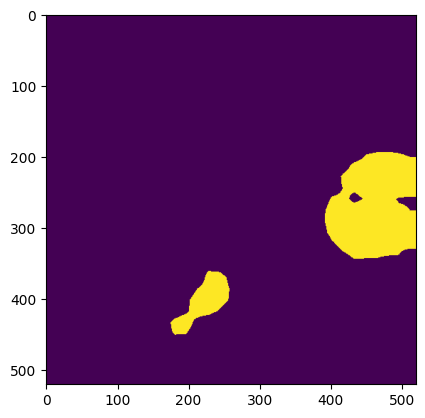

In [40]:
show_result(best_model_path="/content/my_best_checkpoint_sematic_segmentation.pth", model=model)